---
# NOTEBOOK 6 - RECOMMENDER:
---

# PROJECT : Boston Airbnb Fair Pricing Tool and Recommender

# Notebook Overview:
This notebook accomplishes the following:
* Takes user-input data through a prototype user interface
* Uses the user-input data to create a training dataset with matching features
* Trains the best performing random forest regressor model from the previous notebook to make a fair price estimate
* Uses the user-input data to calculate similarity scores between all listings and the user input data
* Creates a list of indexes corresponding with the most similar listings
* Pairs those indexes to the original unformatted data to produce the suggested listings in their original more human-readable format

# 1 - Run Imports and Read-in Data

In [1]:
# Basic Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set a random seed for imputation
#  Source:  https://numpy.org/doc/stable/reference/random/generated/numpy.random.seed.html
np.random.seed(42)

# Sklearn
# from sklearn.linear_model import LinearRegression
# from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# For the recommender
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Read in all data with the full compliment of engineered features
lstn = pd.read_csv('../data/prepped_training.csv')
validation = pd.read_csv('../data/prepped_validation.csv')
test = pd.read_csv('../data/prepped_testing.csv')

# Read in the data with original full-text formatting for the recommender
lstn_full_text = pd.read_csv('../data/listings_train.csv')
validation_full_text = pd.read_csv('../data/listings_val.csv')
testing_full_text = pd.read_csv('../data/listings_test.csv')

# 2 - Create Datasets for Recommender
It's here necessary to read-in both the preprocessed data and the original unprocessed data for the following reasons:
* The preprocessed data is properly formatted and encoded to run in the pricing model.  This is necessary in order to take the user inputs and successfully make a prediction from them based on the training data
    * This is also necessary to calculate the similarity scores between the user input data and all listings provided.  This will then output a suggested list of indexes corresponding to each listing.  This will match up with the listings in the unprocessed data
* The unprocessed data is needed to access the original human-readable listings with all full text information.  Listings will be shown based on the suggested listings output by the recommender
    

#### NOTE ON DATA USAGE:
The pricing model only uses the training to make price predictions, but the recommender will look at all listings across training, validation, and testing.

In [3]:
# Create an aggregated dataframe with ALL engineered features for ALL listings
all_data_full_ft = pd.concat([lstn, validation])
all_data_full_ft = pd.concat([all_data_full_ft, test])
all_data_full_ft.reset_index(drop = True, inplace=True)

In [4]:
# Create an aggregate dataframe with ALL listings in the original full-text format
all_data_full_text = pd.concat([lstn_full_text, validation_full_text])
all_data_full_text = pd.concat([all_data_full_text, testing_full_text])
all_data_full_text.reset_index(drop = True, inplace=True)

In [5]:
# Check that all listings in both datasets are matching, by using the listing latitudes
# which are already formatted as numbers in both and will be unique for each listing
# The code below will out a number euqal the number of rows above if done correctly
sum(all_data_full_ft['latitude'] == all_data_full_text['latitude'])

3864

# 3 - Recommender Data Entry

In [6]:
'''
The purpose of this function is to allow one of the follwoing cells to
be used like a web page where a user would enter data for their desired
Airbnb listing.  Specifically, this function will allow for the empty 
lists next to each of the variables in the cell to operate as text entry 
fields which can be empty if the user chooses to omit that data.

Setting a variable but not equating it to anything will result in errors.

By running this function when a value is entered into on of the empty
text-entry lists, a value is then populated into a list corresponding to
the name of the column corresponding to that variable in the training data.
When nothing, is entered into a text entry list, this function will return 
nothing so that the list corresponding to the training data column will 
remain empty and can be easily dropped with a single dropna function.
'''

def listing_ft_returner(entry_list):
    if len(entry_list) == 1:
        return entry_list[0]
    elif len(entry_list) > 1:
        # Srouce to help with raising an error:
        #  https://rollbar.com/blog/throwing-exceptions-in-python/
        raise Exception('ONLY ONE ENTRY PLEASE!')
    else:
        return

## 3.1 - USER-INTERFACE PROTOTYPE
The code below acts as a user-interface for a user to input their desired characteristics for an Airbnb listing.

To use this, manually input any of the information below into the square brackets following the provided instructions.

In [7]:
# *********************  USER DESIRED AIRBNB LISTING FORM  *********************

# How many peopl ein your party ?
accommodates = [4] # (enter a number)

# How many separate bedrooms would you like?
bedrooms = [] # (enter a number)

# How many beds do you need?
beds = [] # (enter a number)

# What's the minimum number of nights you would plan to stay?
minimum_nightsroom_type_hotel_room = [] # (enter a number)

# Selected room type if desired
room_type_entire_home_apt = [] # enter 1 to select *
room_type_private_room = [] # enter 1 to select
room_type_shared_room = [] # enter 1 to select

# Available now?
has_availability_t = [] # enter 1 to select

# Select your neighborhood if desired
'''
Please select only 1 for best results
'''
allston = [] # enter 1 to select *
back_bay = [] # enter 1 to select
bay_village = [] # enter 1 to select
beacon_hill = [] # enter 1 to select
brighton = [] # enter 1 to select
charlestown = [] # enter 1 to select
chinatown = [] # enter 1 to select
dorchester = [] # enter 1 to select
downtown = [] # enter 1 to select
east_boston = [1] # enter 1 to select
fenway = [] # enter 1 to select
hyde_park = [] # enter 1 to select
jamaica_plain = [] # enter 1 to select
leather_district = [] # enter 1 to select
longwood_medical_area = [] # enter 1 to select
mattapan = [] # enter 1 to select
mission_hill = [] # enter 1 to select
north_end = [] # enter 1 to select
roslindale = [] # enter 1 to select
roxbury = [] # enter 1 to select
south_boston = [] # enter 1 to select
south_boston_waterfront = [] # enter 1 to select
south_end = [] # enter 1 to select
west_end = [] # enter 1 to select
west_roxbury = [] # enter 1 to select


# Select amenties if desired
wifi = [1] # enter 1 to select
kitchen = [] # enter 1 to select
essentials = [] # enter 1 to select
dedicated_workspace = [] # enter 1 to select
pets_allowed = [] # enter 1 to select
gym = [] # enter 1 to select
indoor_fireplace = [] # enter 1 to select
indoor_fireplace_electric = [] # enter 1 to select
fire_pit = [] # enter 1 to select
waterfront = [] # enter 1 to select
free_street_parking = [] # enter 1 to select
free_parking_on_premises = [] # enter 1 to select
patio_or_balcony = [] # enter 1 to select
backyard = [] # enter 1 to select
bbq_grill = [] # enter 1 to select
private_patio_or_balcony = [] # enter 1 to select
outdoor_dining_area = [] # enter 1 to select
pack_n_play_travel_crib = [] # enter 1 to select
childrens_books_and_toys = [] # enter 1 to select
board_games = [] # enter 1 to select
window_guards = [] # enter 1 to select
high_chair = [] # enter 1 to select

# * Note:  These variables were removed during one hot encode ing go nowhere...
#   In a future revision of this program, code must be added to specifically select these features
#    as merely selecting them does not actually zero-out the other columns

## 3.2 - Create Dataframe Based on User Inputs to Predict Value

In [8]:
# This is where all the collumns are to to their vairables inside the functions

# Create the empty dataframe that will bepredicted upon
rec_data = pd.DataFrame(columns=lstn.columns)

# Create all the columns data
rec_data["accommodates"] = [listing_ft_returner(accommodates)]
rec_data["bedrooms"] = [listing_ft_returner(bedrooms)]
rec_data["beds"] = [listing_ft_returner(beds)]
rec_data["minimum_nightsroom_type_Hotel room"] = [listing_ft_returner(minimum_nightsroom_type_hotel_room)]
rec_data["room_type_Private room"] = [listing_ft_returner(room_type_private_room)]
rec_data["room_type_Shared room"] = [listing_ft_returner(room_type_shared_room)]
rec_data["has_availability_t"] = [listing_ft_returner(has_availability_t)]
rec_data["neighbourhood_cleansed_Back Bay"] = [listing_ft_returner(back_bay)]
rec_data["neighbourhood_cleansed_Bay Village"] = [listing_ft_returner(bay_village)]
rec_data["neighbourhood_cleansed_Beacon Hill"] = [listing_ft_returner(beacon_hill)]
rec_data["neighbourhood_cleansed_Brighton"] = [listing_ft_returner(brighton)]
rec_data["neighbourhood_cleansed_Charlestown"] = [listing_ft_returner(charlestown)]
rec_data["neighbourhood_cleansed_Chinatown"] = [listing_ft_returner(chinatown)]
rec_data["neighbourhood_cleansed_Dorchester"] = [listing_ft_returner(dorchester)]
rec_data["neighbourhood_cleansed_Downtown"] = [listing_ft_returner(downtown)]
rec_data["neighbourhood_cleansed_East Boston"] = [listing_ft_returner(east_boston)]
rec_data["neighbourhood_cleansed_Fenway"] = [listing_ft_returner(fenway)]
rec_data["neighbourhood_cleansed_Hyde Park"] = [listing_ft_returner(hyde_park)]
rec_data["neighbourhood_cleansed_Jamaica Plain"] = [listing_ft_returner(jamaica_plain)]
rec_data["neighbourhood_cleansed_Leather District"] = [listing_ft_returner(leather_district)]
rec_data["neighbourhood_cleansed_Longwood Medical Area"] = [listing_ft_returner(longwood_medical_area)]
rec_data["neighbourhood_cleansed_Mattapan"] = [listing_ft_returner(mattapan)]
rec_data["neighbourhood_cleansed_Mission Hill"] = [listing_ft_returner(mission_hill)]
rec_data["neighbourhood_cleansed_North End"] = [listing_ft_returner(north_end)]
rec_data["neighbourhood_cleansed_Roslindale"] = [listing_ft_returner(roslindale)]
rec_data["neighbourhood_cleansed_Roxbury"] = [listing_ft_returner(roxbury)]
rec_data["neighbourhood_cleansed_South Boston"] = [listing_ft_returner(south_boston)]
rec_data["neighbourhood_cleansed_South Boston Waterfront"] = [listing_ft_returner(south_boston_waterfront)]
rec_data["neighbourhood_cleansed_South End"] = [listing_ft_returner(south_end)]
rec_data["neighbourhood_cleansed_West End"] = [listing_ft_returner(west_end)]
rec_data["neighbourhood_cleansed_West Roxbury"] = [listing_ft_returner(west_roxbury)]
rec_data["amen_Wifi"] = [listing_ft_returner(wifi)]
rec_data["amen_Kitchen"] = [listing_ft_returner(kitchen)]
rec_data["amen_Essentials"] = [listing_ft_returner(essentials)]
rec_data["amen_Dedicated workspace"] = [listing_ft_returner(dedicated_workspace)]
rec_data["amen_Pets allowed"] = [listing_ft_returner(pets_allowed)]
rec_data["amen_Gym"] = [listing_ft_returner(gym)]
rec_data["amen_Indoor fireplace"] = [listing_ft_returner(indoor_fireplace)]
rec_data["amen_Indoor fireplace: electric"] = [listing_ft_returner(indoor_fireplace_electric)]
rec_data["amen_Fire pit"] = [listing_ft_returner(fire_pit)]
rec_data["amen_Waterfront"] = [listing_ft_returner(waterfront)]
rec_data["amen_Free street parking"] = [listing_ft_returner(free_street_parking)]
rec_data["amen_Free parking on premises"] = [listing_ft_returner(free_parking_on_premises)]
rec_data["amen_Patio or balcony"] = [listing_ft_returner(patio_or_balcony)]
rec_data["amen_Backyard"] = [listing_ft_returner(backyard)]
rec_data["amen_BBQ grill"] = [listing_ft_returner(bbq_grill)]
rec_data["amen_Private patio or balcony"] = [listing_ft_returner(private_patio_or_balcony)]
rec_data["amen_Outdoor dining area"] = [listing_ft_returner(outdoor_dining_area)]
rec_data["amen_Pack \\u2019n play/Travel crib"] = [listing_ft_returner(pack_n_play_travel_crib)]
rec_data["amen_Children\\u2019s books and toys"] = [listing_ft_returner(childrens_books_and_toys)]
rec_data["amen_Board games"] = [listing_ft_returner(board_games)]
rec_data["amen_Window guards"] = [listing_ft_returner(window_guards)]
rec_data["amen_High chair"] = [listing_ft_returner(high_chair)]

rec_data.dropna(axis=1, inplace=True)
rec_data

,accommodates,neighbourhood_cleansed_East Boston,amen_Wifi
0,4,1,1


# 4 - Predict Listing Price Based on User Inputs

In [9]:
'''
Create a function that will create training and validation datasets based on a list of
input columns against price and log_price data.  Do this only for the X data, y will 
always be the same.
'''

def listing_predictor(data_train, data_to_predict, model):
    
    # X Data    
    X_train_df  = data_train[data_to_predict.columns]
    X_val_df = data_to_predict
    
    # y dataset:    
    y_train = data_train['price']

    # **************  PRICE MODEL  ****************************************
    # Run Models on price
    model_instance = model
    model_instance.fit(X_train_df, y_train)

    # Predict      
    preds_price_val = model_instance.predict(X_val_df)
    
    return round(preds_price_val[0], 2)

In [10]:
# For the predictions, it is imperative to ONLY make predictions based on the training data
rec_predict = listing_predictor(lstn, rec_data, RandomForestRegressor(random_state=42))
rec_predict

167.7

In [11]:
# Repeat above but with outliers removed

# Establish price limits from Notebook 1, 5th and 95th percentile
lower_limit = np.percentile(lstn.price, 5)
upper_limit = np.percentile(lstn.price, 95)

rec_predict_no_outliers = listing_predictor(lstn[(lstn.price >= lower_limit) & (lstn.price <= upper_limit)], rec_data, RandomForestRegressor(random_state=42))
rec_predict_no_outliers

166.48

#### Observations:
Removing the outliers from the training data has only a very minimal effect on the prediction.  This is largely due to the fact that the feature set used to select the columns used in the training data is determined entirely by the user inputs.  Previously, model performance was affected not only by outliers, but also by larger feature sets.  Here, both of those apply far less.  Given this information, it could be suggested that the outliers were not affecting the training of the model so much as simply corrupting the RMSE and r2 calculations with their uniquely high errors.  It appears that the model's ability to predict the prices of more normal listings is about the same with or without the outliers, though more analysis would need to be done to confirm this.

With this however, the pricing model will predict prices using data from the training dataset with the outliers removed, leveraging the rationale from the previous notebook for doing this.

# 5 - Find Similar Listings with Cosine Similarity

In [12]:
# Create a list of columns from the unformatted data that the customer may be interested in viewing
cust_facing_columns = [
 'listing_url',
 'name',
 'description',
 'neighborhood_overview',
 'neighbourhood_cleansed',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'amenities',
 'price',
 'minimum_nights',
 'has_availability',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'instant_bookable']

In [13]:
# Make a list of cosine similarities

sim_dict = {
    'listing_index': [],
    'similarity': [],
    'price': []
}

# Create a variable for the number of recommendations
num_recs = 30

'''
PLAN:
* make this a dictionary of the three values
* convert that dictionary to a dataframe
* Sort the dataframe by similarity, take the top 30
* find the minimum similarity value
* then find all listings with that similarity value
* of those, find the x number cheaper to complete the list of 30 cheapest units

'''

# for index in lstn[lstn.price <300].index:
for index in all_data_full_ft.index:
    
    # Calculate the similarity of the desired listing against each listing
    sim = cosine_similarity([(rec_data.iloc[0]), (all_data_full_ft[rec_data.columns].iloc[index])])[0][1]
    
    # Append the listing index, similarity, and price to the dictionary
    sim_dict['listing_index'].append(index)
    sim_dict['similarity'].append(sim)
    sim_dict['price'].append(all_data_full_ft['price'][index])

# Sort the listings by similarity score (descending) and then price (ascending)
# Soureces for help with this:
# * https://sparkbyexamples.com/pandas/pandas-sort-dataframe-by-multiple-columns/#:~:text=You%20can%20sort%20pandas%20DataFrame,descending%20and%20True%20for%20ascending.
# * https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html
sim_df = pd.DataFrame(sim_dict).sort_values(by=['similarity', 'price'], ascending=[False, True])

In [14]:
# View the dataframe to ensrue proper formatting
sim_df.head(30)

,listing_index,similarity,price
240,240,1.0,83.0
1573,1573,1.0,90.0
980,980,1.0,92.0
2186,2186,1.0,99.0
2120,2120,1.0,100.0
465,465,1.0,110.0
1723,1723,1.0,110.0
346,346,1.0,113.0
3284,3284,1.0,113.0
2660,2660,1.0,133.0


# 6 - USER-INTERFACE OUTPUT PROTOTYPE
# Report Predicted Fair Price, Suggestions, and Price Distribution

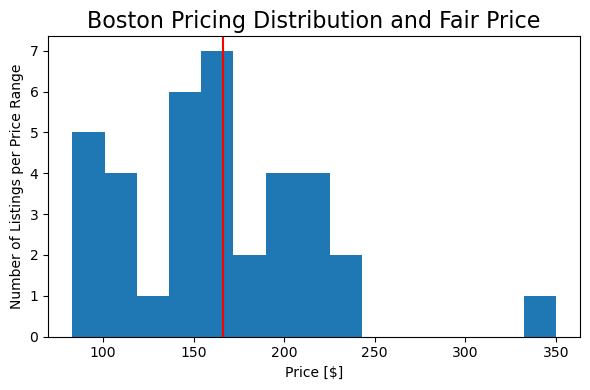

In [15]:
'''
The minimum and maximum similarities must be determined in order to report a logical amount of
of listings.  For example:  If the top n-number of suggestions are all the same similarity, then
technically, all others should be reported with the same similarity score - or at least the prices
for the identical similarity scores.

If the similarity scores are not the same, then simply report the top n-number of listings's prices.
'''
max_sim = sim_df['similarity'][0:num_recs].max()
min_sim = sim_df['similarity'][0:num_recs].min()

if max_sim == min_sim:
    # find all indexzes with that similarity
    suggested_indexes = sim_df[sim_df['similarity'] == min_sim]['listing_index']
    
    # Find all the prices for those indexes suggested above
    suggested_prices = sim_df[sim_df['similarity'] == min_sim]['price']
    
else:
    # Just give the top num_recs similarity differences
    suggested_indexes = sim_df[0:num_recs]['listing_index']
    
    # Find all the prices for those indexes suggested above
    suggested_prices = sim_df[0:num_recs]['price']

plt.figure(figsize = (6, 4))
plt.title('Boston Pricing Distribution and Fair Price', size = 16)
plt.hist(suggested_prices, bins = 15)
plt.xlabel('Price [$]')
plt.ylabel('Number of Listings per Price Range')
plt.axvline(rec_predict_no_outliers, color = 'red')
plt.tight_layout()
plt.savefig('../images/rec_output.png')
plt.show()

In [16]:
# Show listings that will match the criteria

# Change pandas settings to view all the columns
# Source for help: https://builtin.com/data-science/pandas-show-all-columns
pd.set_option('display.max_columns', None)
all_data_full_text.iloc[suggested_indexes][cust_facing_columns]

,listing_url,name,description,neighborhood_overview,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,has_availability,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable
240,https://www.airbnb.com/rooms/50393798,City place with roof top deck/parking/downtown,"My place is cozy, warm and freshly renovated. ...",NaN,East Boston,Entire rental unit,Entire home/apt,4,1 bath,1.0,1.0,"[""Wifi"", ""Keypad"", ""Kitchen"", ""Breakfast"", ""Fi...",$83.00,2,t,78,4.62,4.68,4.64,4.92,4.72,4.65,4.53,t
1573,https://www.airbnb.com/rooms/40991291,Cozy with roof top deck - parking/downtown/air...,"My place is cozy, warm and freshly renovated. ...",NaN,East Boston,Entire rental unit,Entire home/apt,4,1 bath,1.0,2.0,"[""Shampoo"", ""Carbon monoxide alarm"", ""Wifi"", ""...",$90.00,29,t,33,4.55,4.76,4.55,4.88,4.94,4.91,4.61,t
980,https://www.airbnb.com/rooms/15281436,Charming Oasis Near Downtown & Airport,"A Secluded Oasis, with private entrance, close...",NaN,East Boston,Entire condo,Entire home/apt,4,1 bath,NaN,2.0,"[""Shampoo"", ""Carbon monoxide alarm"", ""Wifi"", ""...",$92.00,29,t,62,4.52,4.64,4.57,4.88,4.88,4.78,4.55,f
2186,https://www.airbnb.com/rooms/26105250,Studio Apartment at East Boston Pier Near Water,Executive Studio with Water and City Views in ...,The property is also less than a mile from the...,East Boston,Entire rental unit,Entire home/apt,4,1 bath,NaN,1.0,"[""Wifi"", ""Stove"", ""Kitchen"", ""Dishwasher"", ""Re...",$99.00,91,t,7,4.86,4.71,5.00,4.86,4.86,4.71,5.00,f
2120,https://www.airbnb.com/rooms/50397482,Close to everything - parking/downtown/airport,"My place is cozy, warm and freshly renovated. ...",NaN,East Boston,Entire rental unit,Entire home/apt,4,1 bath,1.0,1.0,"[""Wifi"", ""Keypad"", ""Kitchen"", ""Breakfast"", ""Fi...",$100.00,2,t,65,4.68,4.75,4.77,4.91,4.85,4.71,4.57,t
465,https://www.airbnb.com/rooms/26109264,Beautiful Executive Studio in East Boston EB2-31,Beautiful brand new construction located in Ea...,The property is also less than a mile from the...,East Boston,Entire rental unit,Entire home/apt,4,1 bath,NaN,1.0,"[""Wifi"", ""Stove"", ""Kitchen"", ""Dishwasher"", ""Po...",$110.00,91,t,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f
1723,https://www.airbnb.com/rooms/620273948729922823,Come enjoy Boston - Very Close to Boston by Train,You'll have a great time at this comfortable p...,NaN,East Boston,Entire rental unit,Entire home/apt,4,1 bath,1.0,2.0,"[""Wifi"", ""Carbon monoxide alarm"", ""Keypad"", ""K...",$110.00,1,t,22,3.86,4.09,3.86,4.14,4.09,4.09,3.64,f
346,https://www.airbnb.com/rooms/47953387,Pet-Friendly 2BR in Boston Near Beach & Parks,This stunning home can be found in one of Bost...,NaN,East Boston,Entire serviced apartment,Entire home/apt,4,2 baths,2.0,2.0,"[""Wifi"", ""Stove"", ""Keypad"", ""Kitchen"", ""Dishwa...",$113.00,32,t,3,5.00,5.00,4.67,5.00,4.67,5.00,3.67,f
3284,https://www.airbnb.com/rooms/22918412,Stylish garden level studio with a private patio,Enjoy your stay in this stylish East Boston ga...,Eastie is a bustling neighborhood with restaur...,East Boston,Entire condo,Entire home/apt,4,1 bath,1.0,2.0,"[""Wifi"", ""Public or shared beach access"", ""32\...",$113.00,2,t,88,4.90,4.90,4.97,4.99,4.93,4.93,4.85,f
2660,https://www.airbnb.com/rooms/729674674135522012,Mezzanine Place next to Airport/Downtown,The whole group will enjoy easy access to ever...,NaN,East Boston,Entire rental unit,Entire home/apt,4,1 bath,1.0,1.0,"[""Wifi"", ""Carbon monoxide alarm"", ""Hair dryer""...",$133.00,1,t,34,4.53,4.59,4.62,4.82,4.74,4.74,4.56,t


# 7 - Recommender Conclusions
* A recommender system was able to be developed which would suggest a requested number of Airbnb listings based on user inputs
* The pricing model from the previous notebook was able to be utilized to provide a pricing estimate
    * Despite the poor performance of the model, it was still able to produce an estimate which seems reasonable based on the distribution of similar listings
    * WHen the outliers (below 5th and above 95th percentiles of the price distribution) were removed in the same manner as in the previous notebook to improve model performance, only a \\$1.22 difference was seen between the predictions.  This may suggest that the model is more affected by its ability to predict outliers and not on the outliers affecting the accuracy of the model predictions for more normal listings

# 8 - Recommender Next Steps
* Incorporate a refined pricing model if one is able to be produced
* Create a full prototype by implementing this recommender in a Streamlit app